In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import numpy as np
import torch
from tqdm import tqdm

PATH_SELF_DIR = "."
PATH_MDEC_2025 = "."
SPLIT = "test"
PATH_SYNS_PATCHES_ZIP = f"{PATH_MDEC_2025}/syns_patches.zip"
PATH_OUTPUTS = f"{PATH_SELF_DIR}/visualization_{SPLIT}"
os.makedirs(PATH_OUTPUTS, exist_ok=True)

In [ ]:
import os

PROJECT_PATH = "/content/drive/Shareddrives/Windsor/MDEC"
DATA_PATH = os.path.join(PROJECT_PATH, "Data")
OUTPUT_PATH = os.path.join(PROJECT_PATH, "Output")

In [ ]:
mdec = os.path.join(DATA_PATH, "syns_patches")
split = "test"
split_files_path = os.path.join(mdec, f"splits/{split}_files.txt")

with open(split_files_path) as f:
  split_files = f.read().splitlines()

02 03.png


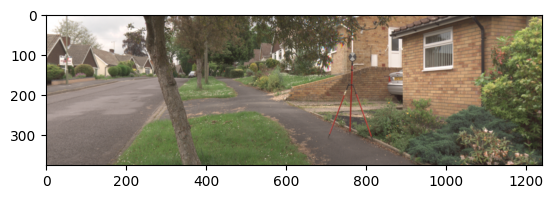

In [ ]:
folder_name, file_name = split_files[0].split()
print(folder_name, file_name)
image_path = os.path.join(mdec, folder_name, "images", file_name)

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

image = Image.open(image_path)
image = np.array(image)
plt.imshow(image)

In [ ]:
os.listdir(OUTPUT_PATH)

['Marigold',
 'DepthAnythingV2',
 'MarigoldLCM',
 'DepthPro',
 'marigold_failed_cases.zip',
 'Marigold_seg',
 'Ensemble_DepthAnythingV2_Marigold',
 '.ipynb_checkpoints',
 'Adjust_v3',
 'DPT-Large-Kitti',
 'pred_test.npz',
 'Ensemble_Felzenszwalb',
 'Felzenszwalb',
 'Untitled Folder',
 'Untitled Folder 1',
 'diffusion-e2e-ft',
 'NYU Ensemble']

In [ ]:
marigold_path = os.path.join(OUTPUT_PATH, "Marigold")
dav2_path = os.path.join(OUTPUT_PATH, "DepthAnythingV2")
print(os.listdir(marigold_path))
print(os.listdir(dav2_path))

['pred.npz', 'visualization_test.zip', 'submission.zip']
['pred.npz', 'visualization_test.zip', 'submission.zip']


In [ ]:
import numpy as np

marigold_pred = np.load(os.path.join(marigold_path, "pred.npz"))
dav2_pred = np.load(os.path.join(dav2_path, "pred.npz"))

In [ ]:
print(marigold_pred['pred'][0].shape)
print(dav2_pred['pred'][0].shape)

(376, 1242)
(376, 1242)


In [ ]:
def convert_disparity_as_affine_invariant(disparity):
    mask_valid = disparity > 0
    depth = 1.0 / np.clip(disparity, a_min=1e-6, a_max=None)
    depth_valid = depth[mask_valid]

    d_min = np.quantile(depth_valid, 0.05)
    d_max = np.quantile(depth_valid, 0.95)
    depth = np.clip((depth - d_min) / np.clip(d_max - d_min, a_min=1e-6, a_max=None), 0, 1)

    return depth

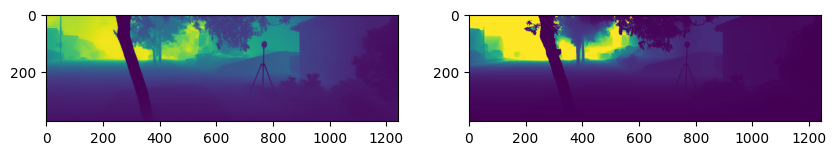

In [ ]:
import matplotlib.pyplot as plt

marigold_img = marigold_pred['pred'][0]
dav2_img = convert_disparity_as_affine_invariant(dav2_pred['pred'][0])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(marigold_img)

plt.subplot(1, 2, 2)
plt.imshow(dav2_img)

In [ ]:
# !pip install -U cython
# !pip install git+https://github.com/lucasb-eyer/pydensecrf.git

In [ ]:
import numpy as np
import cv2
from skimage.segmentation import felzenszwalb

class SegmentsDepthEnsemble:
    def __init__(self, scale=100, sigma=0.8, min_size=50):
        """
        Initialize the shared segments ensemble for depth estimation.
        """
        self.scale = scale
        self.sigma = sigma
        self.min_size = min_size

    def segment_image(self, image):
        """
        Segment the input image into superpixels.
        """
        segments = felzenszwalb(image, scale=self.scale, sigma=self.sigma, min_size=self.min_size)
        return segments

    def compute_segment_features(self, depth_map, segmentation):
        """
        Compute features for each segment in the depth map.
        """
        n_segments = np.max(segmentation) + 1
        features = {}

        for i in range(n_segments):
            mask = (segmentation == i)
            if np.sum(mask) == 0:
                continue

            segment_depth = depth_map[mask]
            mean_depth = np.mean(segment_depth)
            std_depth = np.std(segment_depth)
            confidence = 1 / (std_depth + 1e-5)  # Higher confidence for consistent depth

            features[i] = {
                'mask': mask,
                'mean_depth': mean_depth,
                'std_depth': std_depth,
                'confidence': confidence,
                'size': np.sum(mask)
            }

        return features

    def fuse_depths(self, depth1, depth2, segments1, segments2, image, conf_threshold=1.2):
      """
      Fuse depths with adaptive confidence threshold.
      """
      h, w = depth1.shape
      fused_depth = depth1.copy()  # Start with the first depth map

      # Process each segment
      for segment_id in segments1.keys():
          if segment_id not in segments2:
              continue

          s1 = segments1[segment_id]
          s2 = segments2[segment_id]
          mask = s1['mask']

          # If one segment is fully 1, keep it as 1
          if (s1['mean_depth'] > 0.999 and s1['std_depth'] < 0.001) or \
            (s2['mean_depth'] > 0.999 and s2['std_depth'] < 0.001):
              fused_depth[mask] = 1.0
              continue

          # Only modify segments where the second map offers improvement
          conf_ratio = s2['confidence'] / (s1['confidence'] + 1e-5)
          if conf_ratio > conf_threshold:
              fused_depth[mask] = depth2[mask]

      return fused_depth

    def ensemble_depth_maps(self, depth_map1, depth_map2, image):
        """
        Ensemble two depth maps using shared segmentation.
        """
        # Step 1: Create a single shared segmentation
        segmentation = self.segment_image(image)

        # Step 2: Compute segment features for both depth maps
        segments1 = self.compute_segment_features(depth_map1, segmentation)
        segments2 = self.compute_segment_features(depth_map2, segmentation)

        # Step 3: Fuse depths based on segment features
        fused_depth = self.fuse_depths(depth_map1, depth_map2, segments1, segments2, image)

        return fused_depth

In [ ]:
marigold_imgs = marigold_pred['pred']
dav2_imgs = dav2_pred['pred']

In [ ]:
import cv2

# Initialize and apply the bipartite ensemble
ID = int(input())
folder_name, file_name = split_files[ID].split()
image_path = os.path.join(mdec, folder_name, "images", file_name)
image = Image.open(image_path)
image = np.array(image)

marigold_img = marigold_imgs[ID]
dav2_img = convert_disparity_as_affine_invariant(dav2_imgs[ID])

depth_ensemble = SegmentsDepthEnsemble(scale=200)
refined_depth = depth_ensemble.ensemble_depth_maps(marigold_img, dav2_img, image)

# Save the refined depth map
np.save('refined_depth.npy', refined_depth)

# Visualize the results (normalize for visualization)
depth_vis = (refined_depth - np.min(refined_depth)) / (np.max(refined_depth) - np.min(refined_depth))
cv2.imwrite('refined_depth_visualization.png', (depth_vis * 255).astype(np.uint8))

0


True

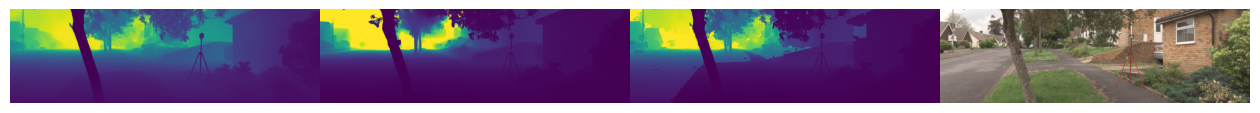

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # 1 row, 4 columns
axs[0].imshow(marigold_img)
axs[1].imshow(dav2_img)
axs[2].imshow(refined_depth)
axs[3].imshow(image)

# Remove axis ticks and labels
for ax in axs:
    ax.axis('off')

# Remove spaces between plots
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Save to PDF
plt.savefig(f'output_{ID}.pdf', bbox_inches='tight', pad_inches=0)
plt.close()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# List of IDs to process
ids = [135, 163, 185, 198, 202, 208, 210, 215, 235, 243]  # Example list of IDs

n = len(ids)
fig = plt.figure(figsize=(16, 1.25 * n))
grid = plt.GridSpec(n, 4, wspace=0, hspace=0)

for i, ID in enumerate(ids):
    folder_name, file_name = split_files[ID].split()
    image_path = os.path.join(mdec, folder_name, "images", file_name)
    image = Image.open(image_path)
    image = np.array(image)

    marigold_img = marigold_imgs[ID]
    dav2_img = convert_disparity_as_affine_invariant(dav2_imgs[ID])

    depth_ensemble = SegmentsDepthEnsemble(scale=200)
    refined_depth = depth_ensemble.ensemble_depth_maps(marigold_img, dav2_img, image)

    # Save the refined depth map
    np.save(f'refined_depth_{ID}.npy', refined_depth)

    # Normalize for visualization
    depth_vis = (refined_depth - np.min(refined_depth)) / (np.max(refined_depth) - np.min(refined_depth))
    cv2.imwrite(f'refined_depth_visualization_{ID}.png', (depth_vis * 255).astype(np.uint8))

    # Plot results
    ax0 = fig.add_subplot(grid[i, 0])
    ax0.imshow(marigold_img, cmap="plasma")
    ax0.axis('off')

    ax1 = fig.add_subplot(grid[i, 1])
    ax1.imshow(dav2_img, cmap="plasma")
    ax1.axis('off')

    ax2 = fig.add_subplot(grid[i, 2])
    ax2.imshow(refined_depth, cmap="plasma")
    ax2.axis('off')

    ax3 = fig.add_subplot(grid[i, 3])
    ax3.imshow(image)
    ax3.axis('off')

# Save to PDF with no padding and tight margins
plt.savefig('output.pdf', bbox_inches='tight', pad_inches=0)
plt.close()

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(marigold_img == refined_depth, cmap="grey")

plt.subplot(1, 2, 2)
plt.imshow(dav2_img == refined_depth, cmap="grey")

In [ ]:
from skimage.segmentation import mark_boundaries
from skimage.segmentation import felzenszwalb

# segments1 = depth_ensemble.segment_image(image, n_segments=100)
# segments2 = depth_ensemble.segment_image(image, n_segments=200)
segments1 = felzenszwalb(image, scale=50, sigma=0.8, min_size=50)
segments2 = felzenszwalb(image, scale=200, sigma=0.8, min_size=50)

print(len(np.unique(segments1)))
print(len(np.unique(segments2)))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(dav2_img, segments1))

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(dav2_img, segments2))

In [ ]:
from diffusers.pipelines.marigold.marigold_image_processing import MarigoldImageProcessor

In [ ]:
def visualize_disparity_as_affine_invariant(disparity):
    mask_valid = disparity > 0
    depth = 1.0 / np.clip(disparity, a_min=1e-6, a_max=None)
    depth_valid = depth[mask_valid]
    d_min = np.quantile(depth_valid, 0.05)
    d_max = np.quantile(depth_valid, 0.95)
    depth = np.clip((depth - d_min) / np.clip(d_max - d_min, a_min=1e-6, a_max=None), 0, 1)
    vis = MarigoldImageProcessor.visualize_depth(depth)
    return vis[0]

In [ ]:
out = []

for idx, split_file in enumerate(tqdm(split_files)):
    folder_name, file_name = split_file.split()
    image_path = os.path.join(mdec, folder_name, "images", file_name)
    image = Image.open(image_path)
    image = np.array(image)
    image = image.astype(np.uint8)

    marigold_img = marigold_imgs[idx]
    dav2_img = convert_disparity_as_affine_invariant(dav2_imgs[idx])

    # depth_ensemble = SharedSegmentsDepthEnsemble(scale=200)
    refined_depth = adaptive_ensemble(image, dav2_img, marigold_img)

    out.append(refined_depth)
    vis = visualize_disparity_as_affine_invariant(refined_depth)
    vis.save(f"{PATH_OUTPUTS}/{idx:04d}_{folder_name}_{file_name}")

out = np.stack(out)
np.savez(f"{PATH_SELF_DIR}/pred_{SPLIT}.npz", pred=out, pred_type="affine-invariant")

In [ ]:
!zip -r visualization_{SPLIT}.zip visualization_{SPLIT}

In [ ]:
import gc

gc.collect()

In [ ]:
!cp /content/pred_test.npz "$OUTPUT_PATH/Felzenszwalb"